In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import sys
sys.path.append("../")
import torch
from torch import nn
from torch import optim
import sys
import itertools

from nf.conditional_prior import ConditionalDiagonalNormal
from nf.nets import MLP

from nf.flows import NormalizingFlow, NormalizingFlowModel, Invertible1x1Conv, ActNorm
from nf.spline_flows import NSF_CL

In [ ]:
import sklearn

sklearn.__version__

import matplotlib

matplotlib.__version__

(256,)
(256, 2)


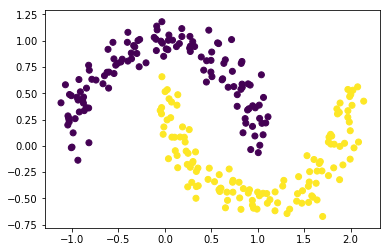

In [2]:
x, y = datasets.make_moons(256, noise=.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

print(y.shape)
print(x.shape)

In [3]:
import numpy as np
y_test = np.tanh(2*y)

len(y_test)
len(y)

y_new = np.array([y, y_test]).T
print(y_new.shape)

print(y_new[:10])

(256, 2)
[[1.         0.96402758]
 [1.         0.96402758]
 [1.         0.96402758]
 [1.         0.96402758]
 [1.         0.96402758]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [1.         0.96402758]]


In [4]:
from torch import nn
from torch import distributions
from torch.distributions import (
    Normal,
    MultivariateNormal,
    Uniform,
    TransformedDistribution,
    SigmoidTransform,
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
elif device.type == "cpu":
    print('Using the cpu...')

Using the cpu...


(256, 2)
[[0.         0.        ]
 [0.         0.        ]
 [1.         0.96402758]
 [1.         0.96402758]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]


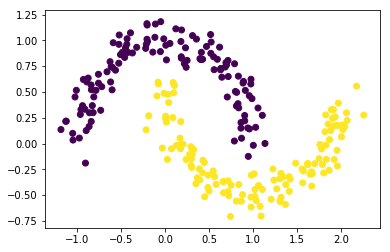

In [6]:

x, y = datasets.make_moons(256, noise=.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

dim = x.shape[-1]

y_test = np.tanh(2*y)

len(y_test)
len(y)

y_new = np.array([y, y_test]).T
print(y_new.shape)

print(y_new[:10])

y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

y_new = torch.tensor(y_new, dtype=torch.float32).reshape(-1, 2)

#num_layers = 5
#base_dist = ConditionalDiagonalNormal(shape=[2], 
#                                     context_encoder=nn.Linear(1, 2*2))

base_mu, base_cov = torch.zeros(dim).to(device), torch.eye(dim).to(device)
prior = MultivariateNormal(base_mu, base_cov)

In [22]:
y_new.shape

torch.Size([128, 2])

In [21]:
y_hel

NameError: name 'y_hel' is not defined

In [7]:
dim = x.shape[-1]

nfs_flow = NSF_CL
flows = [nfs_flow(dim=dim, context_features=2, K=8, B=3, hidden_dim=128) for _ in range(3)]
convs = [Invertible1x1Conv(dim=dim) for _ in flows]
norms = [ActNorm(dim=dim) for _  in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model
model = NormalizingFlowModel(prior, flows)

optimizer = optim.Adam(model.parameters())

x = torch.tensor(x, dtype=torch.float32)

zs, prior_logprob, log_det = model(x, context=y_new)

In [8]:
optimizer = optim.Adam(model.parameters())

num_iter = 100
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y_test = np.tanh(2*y)
    y_new = np.array([y, y_test]).T
    y_new = torch.tensor(y_new, dtype=torch.float32).reshape(-1, 2)
    optimizer.zero_grad()
    zs, prior_logprob, log_det = model(x, context=y_new)
    logprob = prior_logprob + log_det
    loss = -torch.mean(logprob) # NLL
    loss.backward()
    optimizer.step()
    

0
1


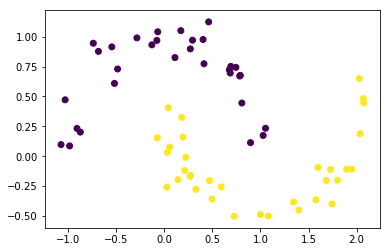

In [20]:

# Load necessary Pytorch packages
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

# Create dataset from several tensors with matching first dimension
# Samples will be drawn from the first dimension (rows)
dataset = TensorDataset(x, y_new)

# Create a data loader from the dataset
# Type of sampling and batch size are specified at this step
loader = DataLoader(dataset, batch_size= 64)

test_1 = []
test_2 = []
for batch_idx, data_batch in enumerate(loader):
    print(batch_idx)
    a, b = data_batch
    test_1.append(a)
    test_2.append(b)
    

len(x)
plt.scatter(test_1[0][:, 0], test_1[0][:, 1], c=test_2[0][:, 0])


In [ ]:
optimizer = optim.Adam(model.parameters())

num_iter = 1000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    optimizer.zero_grad()
    zs, prior_logprob, log_det = model(x, context=y)
    logprob = prior_logprob + log_det
    loss = -torch.mean(logprob) # NLL
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 100 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.75, 3)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            z0, prior_logprob0, log_det0 = model(xyinput, torch.zeros(10000, 1))
            logprob0 = (prior_logprob0 + log_det0).exp().reshape(100, 100)
            z1, prior_logprob1, log_det1 = model(xyinput, torch.ones(10000, 1))
            logprob1 = (prior_logprob1 + log_det1).exp().reshape(100, 100)
            
        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), logprob0.numpy(), cmap='plasma')
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), logprob1.numpy(), cmap='plasma')
        plt.title('iteration {}'.format(i + 1))
        plt.savefig('test.png')
        plt.show()
        
torch.save(model.state_dict(), f'model.pth')

In [ ]:
optimizer = optim.Adam(model.parameters())

num_iter = 1000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    optimizer.zero_grad()
    zs, prior_logprob, log_det = model(x, context=y)
    logprob = prior_logprob + log_det
    loss = -torch.mean(logprob) # NLL
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 100 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.75, 3)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            z0, prior_logprob0, log_det0 = model(xyinput, torch.zeros(10000, 1))
            logprob0 = (prior_logprob0 + log_det0).exp().reshape(100, 100)
            z1, prior_logprob1, log_det1 = model(xyinput, torch.ones(10000, 1))
            logprob1 = (prior_logprob1 + log_det1).exp().reshape(100, 100)
            
        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), logprob0.numpy(), cmap='plasma')
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), logprob1.numpy(), cmap='plasma')
        plt.title('iteration {}'.format(i + 1))
        plt.savefig('test.png')
        plt.show()
        
torch.save(model.state_dict(), f'model.pth')